In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
import scipy

from joblib import Parallel, delayed
from estimagic.inference.bootstrap_estimates import get_bootstrap_estimates

# Bootstrap Monte Carlo Comparison

In this juypter notebook, I perform a Monte Carlo exercise to illustrate the importance of using the cluster robust variant of the bootstrap when data within clusters is correlated. 

The main idea is to repeatedly draw clustered samples, get both uniform and clustered bootstrap estimates in these samples, and then compare how often the true null hypothesis is rejected.

## Data Generating Process

The true data generating process is given by

$$ logit(y_{i,g}) = \beta_0 + \beta_1 (x_{i,g}) + \epsilon_{i,g}, $$

where the independent variable $x_{i,g} = x_i + x_g$ and the noise term $\epsilon_{i,g} = \epsilon_i + \epsilon_g$ each consist of an individual and a cluster term.

In the simulations I perform below, we have $\beta_0 = \beta_1 =0$. $x_i$ and $x_g$ are drawn from a standard normal distribution, and $\epsilon_i$ and $\epsilon_g$ are drawn from a normal distribution with $\mu_0$ and $\sigma=0.5$. The value of $\sigma$ is chosen to not blow up rejection rates in the independent case too much.

In [2]:
def create_clustered_data(nclusters, nobs_per_cluster, true_beta=0):
    """ Create a bivariate clustered dataset with specified number of 
    clusters and number of observations per cluster that has a population
    value of true_beta for the logit coefficient on the independent variable.
    
    Args:
        nclusters (int): number of clusters.
        nobs_per_cluster (int): number of observations per cluster.
        true_beta (int): true logit coefficient on x.
        
    Returns:
        (pd.DataFrame): clustered dataset.
    """
    
    x_cluster = np.random.normal(size=nclusters)
    x_ind = np.random.normal(size=nobs_per_cluster*nclusters)
    eps_cluster = np.random.normal(size=nclusters, scale=0.5)
    eps_ind = np.random.normal(size=nobs_per_cluster*nclusters, scale=0.5)
    
    y = []
    x = []
    cluster = []
    
    for g in range(nclusters):
        
        for i in range(nobs_per_cluster):
            
            key = (i+1)*(g+1)-1
            
            arg = true_beta*(x_cluster[g] + x_ind[key]) + eps_ind[key] + eps_cluster[g]
            
            y_prob = (1/(1+np.exp(-arg)))
            y.append(np.random.binomial(n=1,p=y_prob))
            x.append(x_cluster[g] + x_ind[(i+1)*(g+1)-1])
            cluster.append(g)
    
    y = np.array(y)
    x = np.array(x)
    cluster = np.array(cluster)
            
    return pd.DataFrame({"y":y, "x":x, "cluster": cluster})

## Monte Carlo Simulation Code

The following function computes bootstrap T-values. As suggested my Cameron and Miller (2015), critical values are the 0.975 quantiles from a T distribution with $n_{clusters} -1$ degrees of freedom.

In [3]:
def get_t_values(data, hyp_beta=0, cluster=False):
    """ Get bootstrap t-values for testing the hypothesis that beta = hyp_beta.
    
    Args:
        data (pd.DataFrame): original dataset.
        hyp_beta (float): hypothesised value of beta.
        cluster (bool): whether or not to cluster on the cluster column.
        
    Returns:
        (float): T-Value of hypothesis.
    
    """
    
    def logit_wrap(df):
    
        y = df["y"]
        x = df["x"]

        result = sm.Logit(y,sm.add_constant(x)).fit(disp=0).params

        return pd.Series(result, index=["constant", "x"])
    
    if cluster is False:
        
        estimates = get_bootstrap_estimates(data=data, f=logit_wrap, n_draws=200, n_cores=1)["x"]
    
    else:
        
        estimates = get_bootstrap_estimates(data=data, f=logit_wrap, n_draws=200, n_cores=1, cluster_by="cluster")["x"]
            
    return (estimates.mean()-hyp_beta)/estimates.std()

In [4]:
def monte_carlo(nsim, nclusters, nobs_per_cluster, true_beta=0, n_cores=-1):
    """ Run a Monte Carlo simulation for rejection rates and a logit data generating process.
    Rejection rates are based on a T distribution with nclusters-1 degrees of freedom.
    
    Args:
        nsim (int): number of Monte Carlo draws.
        nclusters (int): number of clusters in each generated dataset.
        nobs_per_cluster (int) number of observations per cluster.
        true_beta (int): population value of logit coefficient on x.
        n_cores (int): number of jobs for Parallelization.
        
    Returns:
        result (pd.DataFrame): DataFrame of average rejection rates.
    """
    
    reject_independent = np.zeros(nsim)
    
    reject_cluster = np.zeros(nsim)
    
    def loop(i):
        
        df = create_clustered_data(nclusters, nobs_per_cluster, true_beta)
        
        return[get_t_values(df),get_t_values(df, cluster=True)]
    
    
    t_value_array = np.array(Parallel(n_jobs=n_cores)(delayed(loop)(i) for i in range(nsim)))
    
    crit = scipy.stats.t.ppf(0.975, nclusters-1)
    
    result = pd.DataFrame(np.abs(t_value_array)>crit, columns=["uniform", "cluster"])
    
    return result


## Results

Here, I perform Monte Carlo simulations with the above functions. In each simulation, the sample size is 1000, but the number of clusters varies across simulations. Be warned that the code below takes a long time to run.

In [5]:
np.random.seed(505)
random.seed(505)

results_list = []

for g,k in [[20, 50], [50, 20], [100, 10], [200, 5], [500, 2]]:
    
    results_list.append(monte_carlo(500, g, k))

In [10]:
mean_rejection_data = pd.DataFrame([x.mean() for x in results_list])
mean_rejection_data["nclusters"] = [20, 50, 100, 200, 500]
mean_rejection_data.set_index("nclusters", inplace=True)

print(mean_rejection_data)

           uniform  cluster
nclusters                  
20           0.152    0.062
50           0.092    0.048
100          0.086    0.060
200          0.062    0.050
500          0.044    0.044


Text(0.5, 0.98, 'Comparison of Rejection Rates')

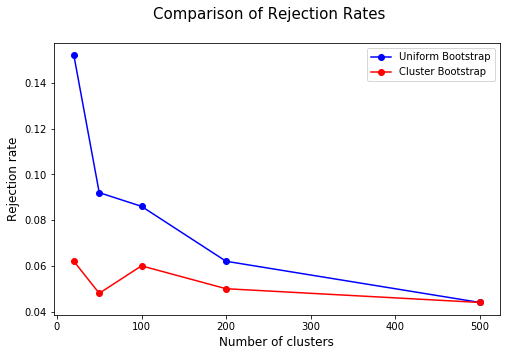

In [12]:
y = mean_rejection_data
x = y.index.values

plt.rcParams["figure.figsize"] = (8,5)
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel('Rejection rate', fontsize=12)
plt.plot(x, y["uniform"], label="Uniform Bootstrap", color="blue", marker="o")
plt.plot(x, y["cluster"], label="Cluster Bootstrap", color="red", marker="o")
plt.legend()
plt.suptitle("Comparison of Rejection Rates", fontsize=15)

We can see that when the number of clusters is low, it is particularly important to use the cluster robust bootstrap, since rejection with the regular bootstrap is excessive. For a large number of clusters, clustering naturally becomes less important. 